# Group Member

In [1]:
import pandas as pd
import os
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from google.cloud import bigquery
import calendar
import math

pd.set_option('display.max_columns', 500)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./license/APMA4990-834091538ff1.json"

# Data Gathering and Preparation

## Data Pipeline

In [2]:
## No need if there is local data

client = bigquery.Client()

query = (
    """
CREATE TEMP FUNCTION RADIANS(x FLOAT64) AS (
  ACOS(-1) * x / 180
);
CREATE TEMP FUNCTION RADIANS_TO_KM(x FLOAT64) AS (
  6371 * 2 * ASIN(SQRT(x))
);
CREATE TEMP FUNCTION HAVERSINE(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
  RADIANS_TO_KM(
        COS(RADIANS(lat1)) * COS(RADIANS(lat2)) *
        POW(SIN(RADIANS(long1)/2 - RADIANS(long2)/2),2) +
        POW(SIN(RADIANS(lat1)/2 - RADIANS(lat2)/2),2))
);
    
CREATE TEMP FUNCTION EUCLIDEAN(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
  SQRT(POW((long1 - long2),2) + POW((lat1 - lat2), 2))                           
);
    
    SELECT * FROM 
    (
        SELECT pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,
        passenger_count,vendor_id,store_and_fwd_flag,
        EXTRACT (DATE FROM pickup_datetime) as date,
        EXTRACT (MONTH FROM pickup_datetime) as month,
        EXTRACT (DAYOFWEEK FROM pickup_datetime) as day,
        EXTRACT (YEAR FROM pickup_datetime) as year,
        EXTRACT (HOUR from pickup_datetime) as hour,
        EUCLIDEAN(dropoff_latitude, dropoff_longitude, pickup_latitude, pickup_longitude) as euc_distance,
        HAVERSINE(dropoff_latitude, dropoff_longitude, pickup_latitude, pickup_longitude) as hav_distance,
        TIMESTAMP_DIFF(dropoff_datetime, pickup_datetime, SECOND) as trip_duration
        FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
        
        WHERE pickup_longitude BETWEEN -75 AND -73
        AND dropoff_longitude BETWEEN -75 AND -73
        AND pickup_latitude BETWEEN 40 AND 42
        AND dropoff_latitude BETWEEN 40 AND 42
        AND HAVERSINE(dropoff_latitude, dropoff_longitude, pickup_latitude, pickup_longitude) BETWEEN 0.1 AND 30
        AND passenger_count BETWEEN 1 AND 4
        AND TIMESTAMP_DIFF(dropoff_datetime, pickup_datetime, SECOND) BETWEEN 60 AND 3600
    ) trip
    INNER JOIN
    (
     SELECT CONCAT(year,'-',mo,'-',da) as date2,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
     FROM `bigquery-public-data.noaa_gsod.gsod2016` 
     WHERE stn = '725053'
     AND temp != 9999.9
     AND visib != 999.9
     AND wdsp != '999.9'
     AND gust != 999.9
     AND max != 9999.9
     AND min != 9999.9
     AND prcp != 99.99
     AND sndp != 999.9
    ) weather
    on CAST(trip.date AS STRING) = weather.date2
    
    ORDER BY RAND()
    LIMIT 100000
    """
)

df=pd.io.gbq.read_gbq(query,dialect='standard')

In [ ]:
# df.to_csv('data.csv',index=False)
df = pd.read_csv('data.csv')

In [4]:
df.head()

,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,vendor_id,store_and_fwd_flag,date,month,day,year,hour,euc_distance,hav_distance,trip_duration,date2,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
0,2016-01-27 20:31:43+00:00,2016-01-27 20:34:00+00:00,-74.006165,40.734589,-74.002579,40.739536,1,1,N,2016-01-27,1,4,2016,20,0.006110,0.627651,137,2016-01-27,43.9,9.9,6.2,22.0,48.0,37.9,0.0,16.9,0,1,0,0,0
1,2016-01-26 20:31:09+00:00,2016-01-26 20:33:03+00:00,-73.957588,40.776600,-73.962326,40.774696,1,1,N,2016-01-26,1,3,2016,20,0.005106,0.451622,114,2016-01-26,41.4,9.8,5.1,25.1,48.0,28.0,0.0,18.9,0,0,0,0,0
2,2016-01-27 10:43:55+00:00,2016-01-27 11:00:09+00:00,-73.968323,40.758636,-73.981621,40.773739,1,1,N,2016-01-27,1,4,2016,10,0.020123,2.018489,974,2016-01-27,43.9,9.9,6.2,22.0,48.0,37.9,0.0,16.9,0,1,0,0,0
3,2016-01-29 23:46:17+00:00,2016-01-29 23:53:13+00:00,-74.000053,40.743515,-74.004303,40.751884,1,1,N,2016-01-29,1,6,2016,23,0.009387,0.997118,416,2016-01-29,38.3,9.5,5.5,22.9,42.1,32.0,0.0,5.9,0,0,0,0,0
4,2016-01-30 10:19:14+00:00,2016-01-30 10:41:46+00:00,-73.961372,40.774693,-74.007011,40.717377,1,1,N,2016-01-30,1,7,2016,10,0.073267,7.443124,1352,2016-01-30,32.8,10.0,6.0,22.0,41.0,28.0,0.0,5.9,0,0,0,0,0


In [5]:
df.shape

(100000, 31)

We fetch data directly from Big Query: `bigquery-public-data.new_york.tlc_yellow_trips_2016`, but delete some useless and unreliable features: payment_type, fare_amount, extra, mta_tax, imp_surcharge, tip_amount, tolls_amount and total_amount from the original dataset. Then we add month, year and trip_duration as additional features.

## Data Integrity Check

 - **pickup_datetime** - date and time when the meter was engaged
 - **dropoff_datetime** - date and time when the meter was disengaged
 - **pickup_longitude** - the longitude where the meter was engaged
 - **pickup_latitude** - the latitude where the meter was engaged
 - **dropoff_longitude** - the longitude where the meter was disengaged
 - **dropoff_latitude** - the latitude where the meter was disengaged
 - **passenger_count** - the number of passengers in the vehicle (driver entered value)
 - **vendor_id** - a code indicating the provider associated with the trip record
 - **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
 - **trip_duration** - duration of the trip in seconds

In [6]:
check_NAN_box = []

for i in df.columns:
    check_NAN_box.append(df[i].isnull().any())

check_NAN_box = pd.DataFrame([check_NAN_box],columns=df.columns)
np.unique(check_NAN_box.values)

array([False])

In [7]:
check_uni_box = []
col = ['vendor_id','store_and_fwd_flag','year','fog','rain_drizzle','snow_ice_pellets','hail','thunder']

for i in col:
    check_uni_box.append(df[i].unique())

check_uni_box = pd.DataFrame([check_uni_box],columns=col)
check_uni_box

,vendor_id,store_and_fwd_flag,year,fog,rain_drizzle,snow_ice_pellets,hail,thunder
0,"[1, 2]","[N, Y]",[2016],"[0, 1]","[1, 0]","[0, 1]",[0],[0]


In [29]:
no_use = ['pickup_datetime','dropoff_datetime','date','date2']
feature_names = [f for f in data.columns if f not in no_use]

def preprocess(data):
    tmp = data[data['year']==2016]
    tmp = tmp[tmp['vendor_id'].isin(['1','2','3'])]
    tmp = tmp[tmp['store_and_fwd_flag'].isin(['Y','N'])]
    tmp = tmp[tmp['fog'].isin(['0','1'])]
    tmp = tmp[tmp['rain_drizzle'].isin(['0','1'])]
    tmp = tmp[tmp['snow_ice_pellets'].isin(['0','1'])]
    tmp = tmp[tmp['hail'].isin(['0','1'])]
    tmp = tmp[tmp['thunder'].isin(['0','1'])]
    
    tmp['store_and_fwd_flag'] = 1 * (tmp['store_and_fwd_flag'].values == 'Y')
    tmp['vendor_id'] = tmp['vendor_id'].astype(int,copy=True,errors='raise') 
    tmp['wdsp'] = tmp['wdsp'].astype(float,copy=True,errors='raise')
    tmp['fog'] = tmp['fog'].astype(int,copy=True,errors='raise')
    tmp['rain_drizzle'] = tmp['rain_drizzle'].astype(int,copy=True,errors='raise')
    tmp['snow_ice_pellets'] = tmp['snow_ice_pellets'].astype(int,copy=True,errors='raise')
    tmp['hail'] = tmp['hail'].astype(int,copy=True,errors='raise')
    tmp['thunder'] = tmp['thunder'].astype(int,copy=True,errors='raise')
    
    return tmp[feature_names]

data = preprocess(df)

In [30]:
data.shape

(100000, 27)

## Feature Engineering

### Trip distance and duration distribution

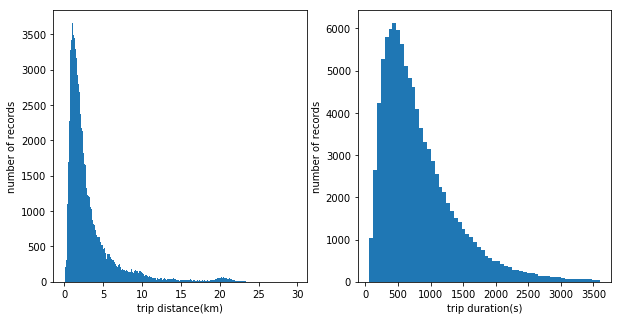

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].hist(data['hav_distance'].values, bins=300)
ax[0].set_xlabel('trip distance(km)')
ax[0].set_ylabel('number of records')

ax[1].hist(data['trip_duration'].values, bins=60)
ax[1].set_xlabel('trip duration(s)')
ax[1].set_ylabel('number of records')

plt.show()

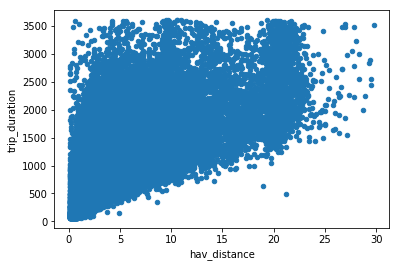

In [11]:
data.plot(x='hav_distance',y='trip_duration',kind='scatter')

### Correlation

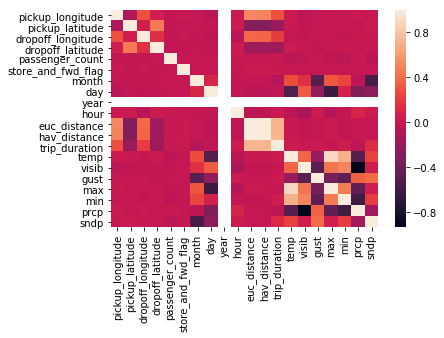

In [12]:
corr = data.corr()
sns.heatmap(corr)

### Trip frequency

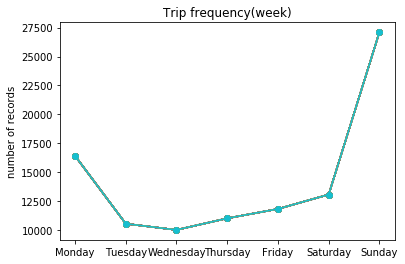

In [15]:
weekDays = ("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")

plt.plot(data.groupby('day').count(),'o-')
plt.title('Trip frequency(week)')
plt.ylabel('number of records')
plt.xticks(np.arange(1,8),weekDays)
plt.show()

### Start point distribution

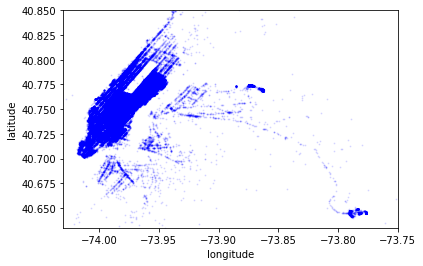

In [61]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.scatter(data['pickup_longitude'].values[:len(data)], data['pickup_latitude'].values[:len(data)],
              color='blue', s=1, label='train', alpha=0.1)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

# Model Selection, Comparison and Cross Validation

## Exploratory Analysis

## Model Selection

In [36]:
X = data.drop('trip_duration',axis=1)
Y = data['trip_duration']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=0.2,random_state=0)

### XGBOOST

In [38]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_val, label=Y_val)
dtest = xgb.DMatrix(X_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Try different parameters! My favorite is random search :)
xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': 4, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [53]:
xgb_model = xgb.train(xgb_pars, dtrain, 1000, watchlist, early_stopping_rounds=50,
                      maximize=False, verbose_eval=10)

[0]	train-rmse:808.964	valid-rmse:807.272
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:294.782	valid-rmse:311.5
[20]	train-rmse:270.5	valid-rmse:295.069
[30]	train-rmse:252.869	valid-rmse:284.159
[40]	train-rmse:242.087	valid-rmse:278.976
[50]	train-rmse:230.99	valid-rmse:274.351
[60]	train-rmse:226.124	valid-rmse:273.032
[70]	train-rmse:223.641	valid-rmse:272.87
[80]	train-rmse:220.79	valid-rmse:272.457
[90]	train-rmse:218.202	valid-rmse:272.103
[100]	train-rmse:216.117	valid-rmse:272.07
[110]	train-rmse:211.286	valid-rmse:270.673
[120]	train-rmse:210.372	valid-rmse:271.019
[130]	train-rmse:208.398	valid-rmse:270.943
[140]	train-rmse:201.373	valid-rmse:267.552
[150]	train-rmse:199.782	valid-rmse:267.86
[160]	train-rmse:198.831	valid-rmse:268.236
[170]	train-rmse:197.659	valid-rmse:268.144
[180]	train-rmse:195.145	valid-rmse:267.939
Stopping. Best iteration:
[137]	train-r

In [55]:
Y_pred = xgb_model.predict(dtest)
r2_score(Y_test,Y_pred)

0.7821258352264342

In [59]:
feature_importance_dict = xgb_model.get_fscore()

feature_importance = pd.DataFrame({'feature name':list(feature_importance_dict.keys()),
                                   'importance':list(feature_importance_dict.values())})

feature_importance.sort_values(by='importance', ascending=False)

,feature name,importance
6,dropoff_latitude,3032
5,dropoff_longitude,2766
14,hav_distance,2511
4,pickup_longitude,2477
7,euc_distance,2233
18,pickup_latitude,2030
11,hour,1703
2,day,484
12,temp,480
13,max,403


### Linear Regression

In [47]:
linear_model = LinearRegression()
linear_model.fit(X_train,Y_train)

Y_pred = linear_model.predict(X_test)
r2_score(Y_test,Y_pred)

0.5667694512549732

### Random Forest Model

In [52]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=0, max_depth=10)
rf_model.fit(X_train,Y_train)
Y_pred = rf_model.predict(X_test)
r2_score(Y_test,Y_pred)

0.7486503364258201